CODE BLOCK: 1

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

In [26]:
# use/update following 4 lines if used in google-drive
#from google.colab import drive
#drive.mount('/content/drive')
#import sys
#sys.path.append("/content/drive/MyDrive/Colab Notebooks/w7_assignment_ERA/")

from model_01 import Net

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


CODE BLOCK: 2

In [27]:
# check if CUDA is available
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [28]:

# Train data transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

# load data sets for training and testing
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms) # flag


CODE BLOCK: 4

In [29]:
# batch size is the number of samples processed before the model is updated
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 5

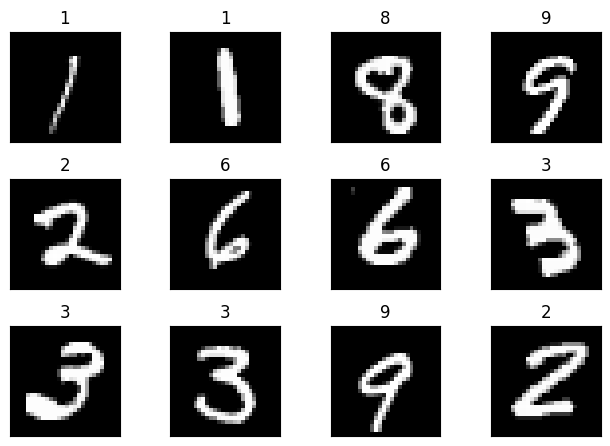

In [30]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 6

In [31]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}


def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 7

In [32]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
#
criterion = nn.CrossEntropyLoss()
num_epochs = 15


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
            Conv2d-2           [-1, 64, 24, 24]          18,432
            Conv2d-3          [-1, 128, 10, 10]          73,728
            Conv2d-4            [-1, 256, 8, 8]         294,912
            Linear-5                   [-1, 50]         204,800
            Linear-6                   [-1, 10]             500
Total params: 592,660
Trainable params: 592,660
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.93
----------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


**CODE** BLOCK: 8

In [33]:

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Epoch 1


Train: Loss=0.3170 Batch_id=117 Accuracy=54.05: 100%|██████████| 118/118 [00:13<00:00,  8.52it/s]


Test set: Average loss: 0.0005, Accuracy: 9289/10000 (92.89%)

Epoch 2


Train: Loss=0.0642 Batch_id=117 Accuracy=95.29: 100%|██████████| 118/118 [00:13<00:00,  8.82it/s]


Test set: Average loss: 0.0002, Accuracy: 9681/10000 (96.81%)

Epoch 3


Train: Loss=0.0797 Batch_id=117 Accuracy=97.21: 100%|██████████| 118/118 [00:13<00:00,  8.91it/s]


Test set: Average loss: 0.0001, Accuracy: 9798/10000 (97.98%)

Epoch 4


Train: Loss=0.0800 Batch_id=117 Accuracy=97.94: 100%|██████████| 118/118 [00:13<00:00,  9.05it/s]


Test set: Average loss: 0.0001, Accuracy: 9837/10000 (98.37%)

Epoch 5


Train: Loss=0.0131 Batch_id=117 Accuracy=98.20: 100%|██████████| 118/118 [00:13<00:00,  8.47it/s]


Test set: Average loss: 0.0001, Accuracy: 9860/10000 (98.60%)

Epoch 6


Train: Loss=0.0475 Batch_id=117 Accuracy=98.57: 100%|██████████| 118/118 [00:12<00:00,  9.11it/s]


Test set: Average loss: 0.0001, Accuracy: 9860/10000 (98.60%)

Epoch 7


Train: Loss=0.0164 Batch_id=117 Accuracy=98.78: 100%|██████████| 118/118 [00:12<00:00,  9.34it/s]


Test set: Average loss: 0.0001, Accuracy: 9878/10000 (98.78%)

Epoch 8


Train: Loss=0.0670 Batch_id=117 Accuracy=98.91: 100%|██████████| 118/118 [00:13<00:00,  8.81it/s]


Test set: Average loss: 0.0001, Accuracy: 9889/10000 (98.89%)

Epoch 9


Train: Loss=0.0955 Batch_id=117 Accuracy=98.93: 100%|██████████| 118/118 [00:13<00:00,  8.85it/s]


Test set: Average loss: 0.0001, Accuracy: 9896/10000 (98.96%)

Epoch 10


Train: Loss=0.0569 Batch_id=117 Accuracy=99.09: 100%|██████████| 118/118 [00:13<00:00,  8.91it/s]


Test set: Average loss: 0.0001, Accuracy: 9900/10000 (99.00%)

Epoch 11


Train: Loss=0.0023 Batch_id=117 Accuracy=99.18: 100%|██████████| 118/118 [00:13<00:00,  9.04it/s]


Test set: Average loss: 0.0001, Accuracy: 9897/10000 (98.97%)

Epoch 12


Train: Loss=0.0062 Batch_id=117 Accuracy=99.28: 100%|██████████| 118/118 [00:13<00:00,  8.44it/s]


Test set: Average loss: 0.0001, Accuracy: 9892/10000 (98.92%)

Epoch 13


Train: Loss=0.0123 Batch_id=117 Accuracy=99.29: 100%|██████████| 118/118 [00:13<00:00,  8.82it/s]


Test set: Average loss: 0.0001, Accuracy: 9886/10000 (98.86%)

Epoch 14


Train: Loss=0.0037 Batch_id=117 Accuracy=99.33: 100%|██████████| 118/118 [00:13<00:00,  9.04it/s]


Test set: Average loss: 0.0001, Accuracy: 9895/10000 (98.95%)

Epoch 15


Train: Loss=0.0028 Batch_id=117 Accuracy=99.37: 100%|██████████| 118/118 [00:12<00:00,  9.26it/s]


Test set: Average loss: 0.0001, Accuracy: 9895/10000 (98.95%)



**CODE** BLOCK: 9

Text(0.5, 1.0, 'Test Accuracy')

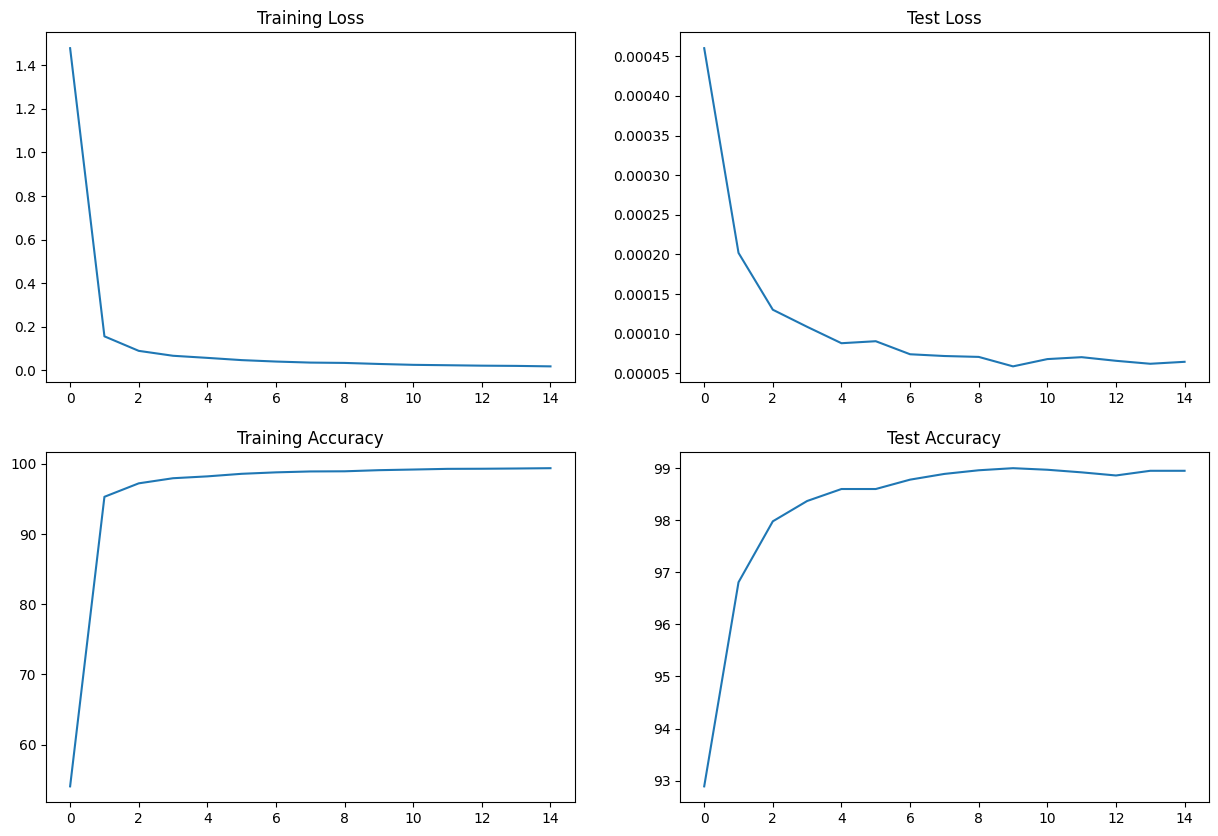

In [34]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [35]:

min_train_loss_epoch = train_losses.index(min(train_losses)) + 1
min_test_loss_epoch = test_losses.index(min(test_losses)) + 1
best_train_acc_epoch = train_acc.index(max(train_acc)) + 1
best_test_acc_epoch = test_acc.index(max(test_acc)) + 1

print("Minimum training loss = {:.9f}% at epoch {}".format(min(train_losses), min_train_loss_epoch))
print("Minimum testing loss = {:.9f}% at epoch {}".format(min(test_losses), min_test_loss_epoch))
print("Best training accuracy = {:.2f}% at epoch {}".format(max(train_acc), best_train_acc_epoch))
print("Best testing accuracy = {:.2f}% at epoch {}".format(max(test_acc), best_test_acc_epoch))


Minimum training loss = 0.018815884% at epoch 15
Minimum testing loss = 0.000058608% at epoch 10
Best training accuracy = 99.37% at epoch 15
Best testing accuracy = 99.00% at epoch 10


##**Target**

- Use modular code to generate first set of results
- Establish the code flow
- Use old model to begin with

##**Results:**

- Total parameters: 592,660
- Best train accuracy: 99.37% at epoch 15
- Best test accuracy: 99.00% at epoch 10

# **Analysis**

- As expected, the model has huge number of parameters
- The model is overfitted
- Next step should have very few parameters and proper `conv` blocks